# Random Walk - TLDR

- Using the GOOGL dataset & apply the forecasting techniques measure their performance as follows:
    - Keep the last 5 days of data as a test set. The rest will be the train set.
    - Forecast the last 5 days of the closing price using naive forecasting methods and measure the MSE. Which method is the best?
    - Plot your forecasts.

In [26]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf

import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv("../data/book-time-series-forecasting-in-python/GOOGL.csv", parse_dates=[0])
train_df = df[['Date','Close']][:-5]
test_df = df[['Date','Close']][-5:]

## EDA 
- This step is to decide if Googl "Close" price is a random walk ?
    - A random walk is the series which is **stationary** (ADF test) and **un-correlated** (ACF plot) after a first-order differencing
    - Step 1: test for stationarity (ADF, KPSS test). 
        - If it is not stationary, we apply transformations (differencing or log) until stationarity is achieved. 
    - Step 2: Then we can plot the autocorrelation function (ACF).
        - If there is no autocorrelation, we have a random walk.

In [4]:
def check_stationarity(series, p_significant=0.05):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    adfuller_result = adfuller(series)
    kpss_result = kpss(series)

    print(f'ADF Statistic : {adfuller_result[0]:.5f}, p-value: {adfuller_result[1]:.5f}')
    print('Critical Values:')
    for key, value in adfuller_result[4].items():
        print('\t%s: %.3f' % (key, value))
    print(f'KPSS Statistic: {kpss_result[0]:.5f}, p-value: {kpss_result[1]:.5f}')
    if (adfuller_result[1] <= p_significant) & (adfuller_result[4]['5%'] > adfuller_result[0]) & (kpss_result[1] > p_significant):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [8]:
# Keep the last five days to test your forecasts
check_stationarity(train_df['Close'])

ADF Statistic : 0.20726, p-value: 0.97267
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573
KPSS Statistic: 2.14281, p-value: 0.01000
Non-stationary


- As the time-series is non-stationary, we will have to apply transformation (differencing) to stationarise the time-series.

In [21]:
diff_train_arr = np.diff(train_df['Close'], n=1)
check_stationarity(diff_train_arr)

ADF Statistic : -5.23866, p-value: 0.00001
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573
KPSS Statistic: 0.08473, p-value: 0.10000
Stationary


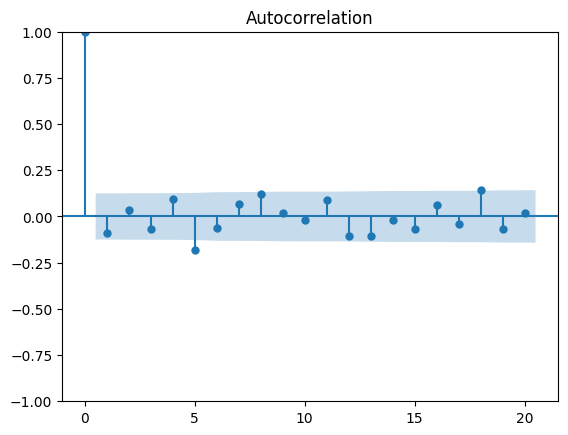

In [24]:
# Because our random walk is not stationary, we need to apply a transformation (differencing) to make it stationary in order to retrieve useful information from the ACF plot.
plot_acf(diff_train_arr, lags=20); 

- The shaded area represents a confidence interval. 
    - If a point is within the shaded area, then it is not significantly
    - Otherwise, the autocorrelation coefficient is significant.
- From the above plot, there are no significant coefficients after lag 0, or the first-order differencing of the Google "Close" price are un-correlated with its lags.
- Hence, this is a clear indicator that Google "Close" price is a random walk

## Forecasting with a Random Walk
- Because a random walk process takes random steps into the future, we **cannot use statistical or deep learning** techniques to fit such a process: there is **nothing to learn from randomness** and it cannot be predicted. Instead, we must **rely on naive forecasting methods**.
- Naive forecasting methods for this situation:
  - **Historical mean**
  - **Last known value**
  - **Drift method**: a modification of predicting the last known value.
    - In this case, we allow the values to increase or decrease over time.
    - The rate at which values will change in the future is equal to that seen in the train set.
    - Therefore, it is equivalent to calculating the slope between the first and last value of the train set and simply extrapolating this straight line into the future.
      - $y_f$ the last value in the training set
      - $y_i$ the initial value in the training set
        $$\text{slope (drift)}= \frac{\Delta y}{\Delta x} = \frac {y_f - y_i}{\text{number of timesteps} - 1}$$
        $$forecast = slope * timestep + y_i$$
  - **Forecasting the next timestep using the previous value**
    - For example: the observed value at 8:00 a.m. is used to forecast the value for 9:00 a.m., the actual value observed at 9:00 a.m. is used to forecast the value at 10:00 a.m., and so on.
    <p align="center"><img src="../assets/img/forecasting-next-timestep.png" width=600></p>


In [25]:
# Forecast the historical mean
mean = np.mean(train_df['Close'])
test_df.loc[:, 'pred_mean'] = mean

# Forecast using the last knwon value
last_value = train_df['Close'].iloc[-1]
test_df.loc[:, 'pred_last'] = last_value

# Forecast using the drift
delta_x = len(train_df)    # The deltaX is basically the length of the training set
delta_y = last_value - train_df['Close'].iloc[0]    # Remember to subtract the initial value of the training set

drift = delta_y / delta_x

x_vals = np.arange(248, 253, 1)

pred_drift = drift * x_vals + train_df['Close'].iloc[0]    #A Add the initial value back in the predictions

test_df.loc[:, 'pred_drift'] = pred_drift

In [27]:
googl_mse_mean = mean_squared_error(test_df['Close'], test_df['pred_mean'])
googl_mse_last = mean_squared_error(test_df['Close'], test_df['pred_last'])
googl_mse_drift = mean_squared_error(test_df['Close'], test_df['pred_drift'])

print(googl_mse_mean, googl_mse_last, googl_mse_drift)

356025.96701539395 447.82398976418415 293.3287644069853


In [29]:
# Forecast the next timestep with the previous timestep's value
df_shift = df.shift(1)
mse_one_step = mean_squared_error(test_df['Close'], df_shift['Close'].iloc[-5:])
print(mse_one_step)

674.8857699967758


- In this example, the drift method yields the best result